In [74]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from IPython import display

In [2]:
directory_path = r'C:\Users\darkc\OneDrive\Documents\MICA\Viz in Practice\Viz_In_Practice'
os.chdir(directory_path)

In [3]:
cp = pd.read_csv('Children in poverty.csv')
ei = pd.read_csv('EITC_data.csv')

In [4]:
abs_cp = cp[cp['DataFormat'] == 'Number'].copy()
prct_df = cp[cp['DataFormat'] == 'Percent'].copy()
abs_cp = abs_cp.rename(columns={'Data': 'Children_in_Poverty'})
abs_cp = abs_cp.drop('DataFormat', axis=1)
prct_df = prct_df.rename(columns={'Data': 'Percent_Child_Poverty'})
prct_df = prct_df.drop('DataFormat', axis=1)
cp2 = pd.merge(abs_cp, prct_df, on=['Location', 'TimeFrame'])
cp2 = cp2.drop('LocationType_y', axis=1)

In [5]:
print(cp2.head())

  LocationType_x       Location  TimeFrame Children_in_Poverty  \
0         Nation  United States       2000            12209000   
1          State        Alabama       2000              233000   
2          State         Alaska       2000               25000   
3          State        Arizona       2000              310000   
4          State       Arkansas       2000              168000   

  Percent_Child_Poverty  
0                  0.17  
1                  0.21  
2                  0.13  
3                  0.23  
4                  0.25  


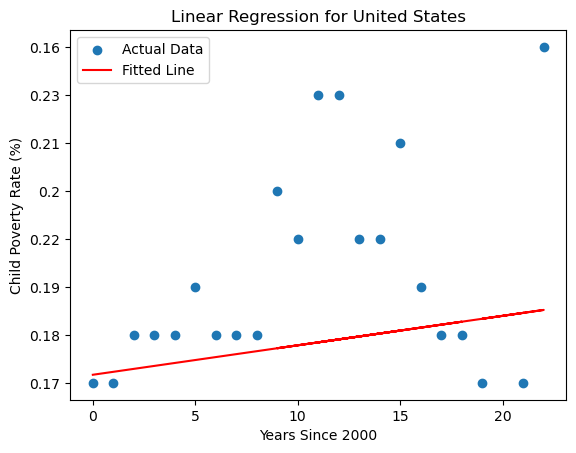

In [32]:
cp2 = cp2[cp2['Location'] != 'Puerto Rico']
cp2_states = cp2[cp2['Location'] == state]

states = cp2['Location'].unique()

regression_results = []

def custom_linregress(x, y, intercept):
    slope, _, r_value, _, _ = linregress(x, y)
    return slope * x + intercept, r_value

for state in states:
    state_data = cp2[cp2['Location'] == state]

    if len(state_data) > 1:

        years_since_2000 = state_data['TimeFrame'] - 2000  # Use years since 2000 as x-values
        percent_poverty_values = pd.to_numeric(state_data['Percent_Child_Poverty'], errors='coerce')

        adjusted_values = percent_poverty_values - percent_poverty_values[state_data['TimeFrame'] == 2000].values[0]

        cleaned_data = pd.DataFrame({'YearsSince2000': years_since_2000, 'Values': adjusted_values}).dropna()

        intercept = percent_poverty_values[state_data['TimeFrame'] == 2000].values[0]
        fitted_values, r_value = custom_linregress(cleaned_data['YearsSince2000'], cleaned_data['Values'], intercept)

        regression_results.append({
            'State': state,
            'Intercept (2000)': intercept,
            'Slope': r_value,
        })

example_state = regression_results[0]['State']
example_data = cp2[cp2['Location'] == example_state]
plt.scatter(example_data['TimeFrame'] - 2000, example_data['Percent_Child_Poverty'], label='Actual Data')
plt.plot(example_data['TimeFrame'] - 2000, regression_results[0]['Intercept (2000)'] + regression_results[0]['Slope'] * (example_data['TimeFrame'] - 2000), color='red', label='Fitted Line')
plt.xlabel('Years Since 2000')
plt.ylabel('Child Poverty Rate (%)')
plt.title(f'Linear Regression for {example_state}')
plt.legend()
plt.show()

In [33]:
regression_results_df = pd.DataFrame(regression_results)
regression_results_df.head()

,State,Intercept (2000),Slope
0,United States,0.17,0.061395
1,Alabama,0.21,0.098493
2,Alaska,0.13,0.413285
3,Arizona,0.23,-0.061900
4,Arkansas,0.25,-0.074645


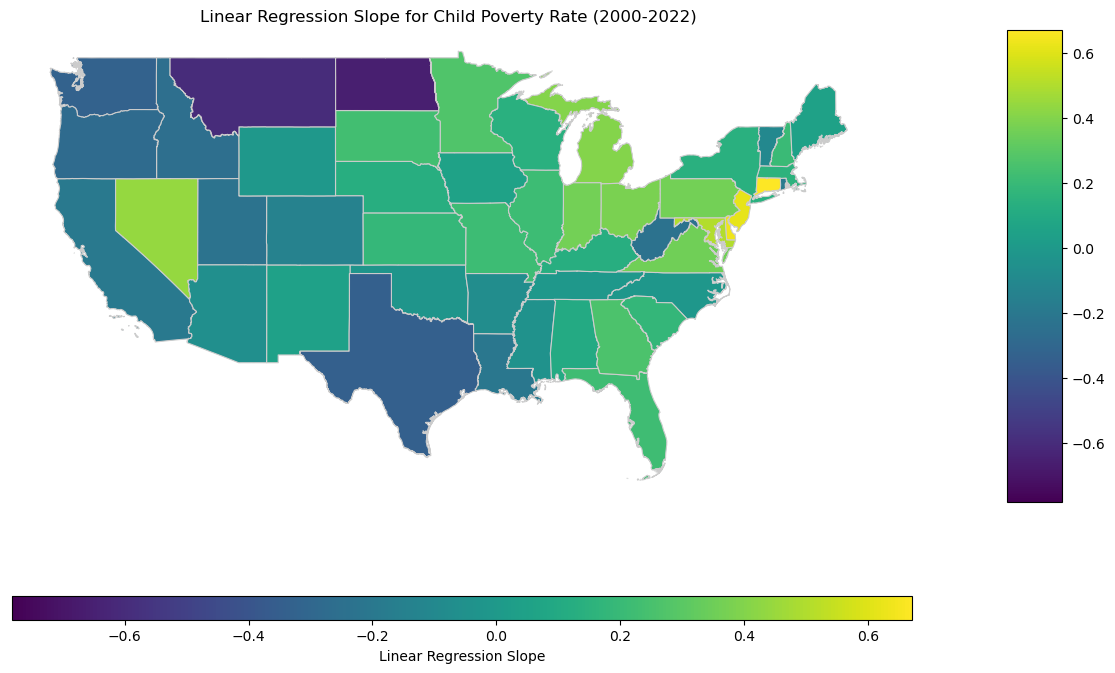

In [34]:
regression_results_df = pd.DataFrame(regression_results)

regression_results_df1 = regression_results_df[(regression_results_df['State'].isin(['Alaska', 'Hawaii']) == False)].copy()

shapefile_path = 'cb_2018_us_state_500k.shp'
usa = gpd.read_file(shapefile_path)

# Merge shapefile with regression results
merged_df = usa.merge(regression_results_df1, left_on='NAME', right_on='State')

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the slope on the map for each state
merged_df.plot(column='Slope', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)

ax.set_title('Linear Regression Slope for Child Poverty Rate (2000-2022)')
ax.set_axis_off()

# Add a colorbar directly to the plot
cax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=merged_df['Slope'].min(), vmax=merged_df['Slope'].max()))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='horizontal', label="Linear Regression Slope")

plt.show()


In [35]:
cp2['Year'] = pd.to_numeric(cp2['TimeFrame'], errors='coerce')
cp2_filtered = cp2[cp2['TimeFrame'] >= 2000].copy()
cp2_filtered.sort_values(by=['Location', 'TimeFrame'], inplace=True)
cp2_filtered['Children_in_Poverty'] = pd.to_numeric(cp2_filtered['Children_in_Poverty'], errors='coerce')
cp2_filtered['Percent_Child_Poverty'] = pd.to_numeric(cp2_filtered['Percent_Child_Poverty'], errors='coerce')

In [36]:
# YOY Child Poverty
cp2_filtered['YoY_Change_Absolute_Poverty'] = cp2_filtered.groupby('Location')['Children_in_Poverty'].diff()

cp2_filtered['YoY_Pct_Change_Absolute_Poverty'] = (
    cp2_filtered.groupby('Location')['Children_in_Poverty']
    .pct_change(fill_method=None) * 100
)

cp2_filtered['YoY_Child_Poverty_Percent'] = cp2_filtered.groupby('Location')['Percent_Child_Poverty'].diff()


In [37]:
print(cp2_filtered.head())

    LocationType_x Location  TimeFrame  Children_in_Poverty  \
1            State  Alabama       2000               233000   
104          State  Alabama       2001               253000   
107          State  Alabama       2002               255000   
210          State  Alabama       2003               255000   
213          State  Alabama       2004               249000   

     Percent_Child_Poverty  Year  YoY_Change_Absolute_Poverty  \
1                     0.21  2000                          NaN   
104                   0.23  2001                      20000.0   
107                   0.24  2002                       2000.0   
210                   0.24  2003                          0.0   
213                   0.23  2004                      -6000.0   

     YoY_Pct_Change_Absolute_Poverty  YoY_Child_Poverty_Percent  
1                                NaN                        NaN  
104                         8.583691                       0.02  
107                         0.79

In [38]:
cp2_fstate = cp2_filtered[cp2_filtered['LocationType_x'] == 'State'].copy()
cp2_fus = cp2_filtered[cp2_filtered['LocationType_x'] == 'Nation'].copy()

In [39]:
ei_lagged = ei.copy()
ei_lagged['data_Lagged'] = ei_lagged.groupby('statecode')['data'].shift(-1)

ei_lagged.head()

,EITC_id,dataset,statecode,statistic,statid,year,data,Statename,NDecimals,StateAbbrev,data_Lagged
0,1,EIC,99,EIC_totalreturns_state,301,1995,19344000.0,United States,2.0,US,19404580.0
1,2,EIC,99,EIC_totalreturns_state,301,1996,19404580.0,United States,2.0,US,19817658.0
2,3,EIC,1,EIC_totalreturns_state,301,1996,455700.0,Alabama,2.0,AL,460087.0
3,4,EIC,2,EIC_totalreturns_state,301,1996,29163.0,Alaska,2.0,AK,30442.0
4,5,EIC,3,EIC_totalreturns_state,301,1996,340744.0,Arizona,2.0,AZ,347168.0


In [40]:
## Merge into one dataset (states)

merged_data = pd.merge(
    cp2_fstate,  # Use the filtered cp2 DataFrame for states only
    ei_lagged[ei_lagged['statistic'] == 'EIC_totalreturns_state'],
    left_on=['Location', 'TimeFrame'],
    right_on=['Statename', 'year']
)

merged_data.head()

,LocationType_x,Location,TimeFrame,Children_in_Poverty,Percent_Child_Poverty,Year,YoY_Change_Absolute_Poverty,YoY_Pct_Change_Absolute_Poverty,YoY_Child_Poverty_Percent,EITC_id,dataset,statecode,statistic,statid,year,data,Statename,NDecimals,StateAbbrev,data_Lagged
0,State,Alabama,2000,233000,0.21,2000,NaN,NaN,NaN,211,EIC,1,EIC_totalreturns_state,301,2000,442954.0,Alabama,2.0,AL,447392.0
1,State,Alabama,2001,253000,0.23,2001,20000.0,8.583691,0.02,263,EIC,1,EIC_totalreturns_state,301,2001,447392.0,Alabama,2.0,AL,477939.0
2,State,Alabama,2002,255000,0.24,2002,2000.0,0.790514,0.01,315,EIC,1,EIC_totalreturns_state,301,2002,477939.0,Alabama,2.0,AL,484769.0
3,State,Alabama,2003,255000,0.24,2003,0.0,0.000000,0.00,367,EIC,1,EIC_totalreturns_state,301,2003,484769.0,Alabama,2.0,AL,490840.0
4,State,Alabama,2004,249000,0.23,2004,-6000.0,-2.352941,-0.01,419,EIC,1,EIC_totalreturns_state,301,2004,490840.0,Alabama,2.0,AL,502914.0


In [41]:
selected_columns = ['YoY_Child_Poverty_Percent', 'YoY_Change_Absolute_Poverty', 'YoY_Pct_Change_Absolute_Poverty', 'Children_in_Poverty', 'data']

correlation_matrix = merged_data[selected_columns].corr()

print(correlation_matrix)

                                 YoY_Child_Poverty_Percent  \
YoY_Child_Poverty_Percent                         1.000000   
YoY_Change_Absolute_Poverty                       0.573939   
YoY_Pct_Change_Absolute_Poverty                   0.898369   
Children_in_Poverty                               0.020045   
data                                              0.016402   

                                 YoY_Change_Absolute_Poverty  \
YoY_Child_Poverty_Percent                           0.573939   
YoY_Change_Absolute_Poverty                         1.000000   
YoY_Pct_Change_Absolute_Poverty                     0.550222   
Children_in_Poverty                                 0.254184   
data                                                0.258633   

                                 YoY_Pct_Change_Absolute_Poverty  \
YoY_Child_Poverty_Percent                               0.898369   
YoY_Change_Absolute_Poverty                             0.550222   
YoY_Pct_Change_Absolute_Poverty       

The amount of children in poverty is positively correlated with the amount of money given out.
The %change in poverty is not a

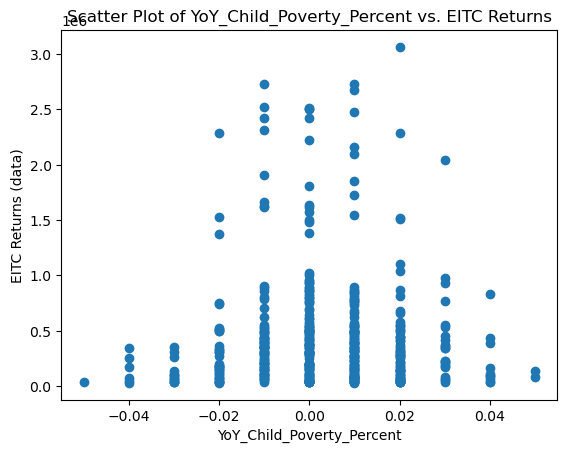

In [42]:
plt.scatter(merged_data['YoY_Child_Poverty_Percent'], merged_data['data'])
plt.title('Scatter Plot of YoY_Child_Poverty_Percent vs. EITC Returns')
plt.xlabel('YoY_Child_Poverty_Percent')
plt.ylabel('EITC Returns (data)')
plt.show()

In [46]:
## Merge into one dataset (states)

merged_us_data = pd.merge(
    cp2_fus,
    ei_lagged[ei_lagged['statistic'] == 'EIC_totalreturns_state'],
    left_on=['Location', 'TimeFrame'],
    right_on=['Statename', 'year']
)

merged_us_data.head()

,LocationType_x,Location,TimeFrame,Children_in_Poverty,Percent_Child_Poverty,Year,YoY_Change_Absolute_Poverty,YoY_Pct_Change_Absolute_Poverty,YoY_Child_Poverty_Percent,EITC_id,dataset,statecode,statistic,statid,year,data,Statename,NDecimals,StateAbbrev,data_Lagged
0,Nation,United States,2000,12209000,0.17,2000,NaN,NaN,NaN,210,EIC,99,EIC_totalreturns_state,301,2000,19166052.0,United States,2.0,US,19656992.0
1,Nation,United States,2001,11962000,0.17,2001,-247000.0,-2.023098,0.00,262,EIC,99,EIC_totalreturns_state,301,2001,19656992.0,United States,2.0,US,21574486.0
2,Nation,United States,2002,12518000,0.18,2002,556000.0,4.648052,0.01,314,EIC,99,EIC_totalreturns_state,301,2002,21574486.0,United States,2.0,US,22111802.0
3,Nation,United States,2003,12673000,0.18,2003,155000.0,1.238217,0.00,366,EIC,99,EIC_totalreturns_state,301,2003,22111802.0,United States,2.0,US,22418110.0
4,Nation,United States,2004,13245000,0.18,2004,572000.0,4.513533,0.00,418,EIC,99,EIC_totalreturns_state,301,2004,22418110.0,United States,2.0,US,22747632.0


In [47]:
us_correlation_matrix = merged_us_data[selected_columns].corr()

print(us_correlation_matrix)

                                 YoY_Child_Poverty_Percent  \
YoY_Child_Poverty_Percent                         1.000000   
YoY_Change_Absolute_Poverty                       0.771293   
YoY_Pct_Change_Absolute_Poverty                   0.767906   
Children_in_Poverty                               0.499236   
data                                              0.411911   

                                 YoY_Change_Absolute_Poverty  \
YoY_Child_Poverty_Percent                           0.771293   
YoY_Change_Absolute_Poverty                         1.000000   
YoY_Pct_Change_Absolute_Poverty                     0.999198   
Children_in_Poverty                                 0.712060   
data                                                0.567201   

                                 YoY_Pct_Change_Absolute_Poverty  \
YoY_Child_Poverty_Percent                               0.767906   
YoY_Change_Absolute_Poverty                             0.999198   
YoY_Pct_Change_Absolute_Poverty       

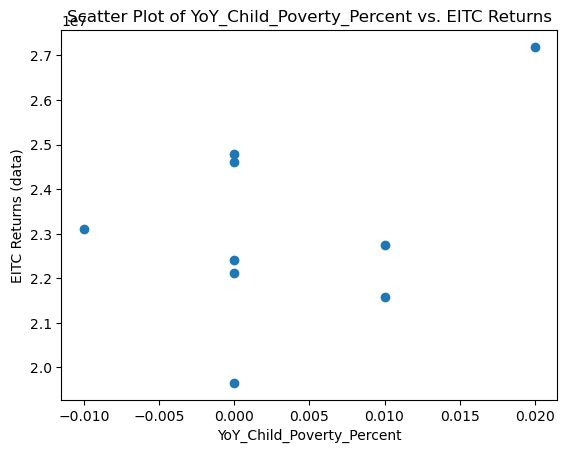

In [49]:
plt.scatter(merged_us_data['YoY_Child_Poverty_Percent'], merged_us_data['data'])
plt.title('Scatter Plot of YoY_Child_Poverty_Percent vs. EITC Returns')
plt.xlabel('YoY_Child_Poverty_Percent')
plt.ylabel('EITC Returns (data)')
plt.show()

In [80]:
print(sorted_data.head())

  LocationType_x       Location  TimeFrame  Children_in_Poverty  \
0         Nation  United States       2000             12209000   
1         Nation  United States       2001             11962000   
2         Nation  United States       2002             12518000   
3         Nation  United States       2003             12673000   
4         Nation  United States       2004             13245000   

   Percent_Child_Poverty  Year  YoY_Change_Absolute_Poverty  \
0                   0.17  2000                          NaN   
1                   0.17  2001                    -247000.0   
2                   0.18  2002                     556000.0   
3                   0.18  2003                     155000.0   
4                   0.18  2004                     572000.0   

   YoY_Pct_Change_Absolute_Poverty  YoY_Child_Poverty_Percent  EITC_id  \
0                              NaN                        NaN      210   
1                        -2.023098                       0.00      262

In [95]:
sorted_data = merged_us_data.sort_values(by='TimeFrame')

sorted_data = sorted_data.dropna(subset=['YoY_Change_Absolute_Poverty', 'YoY_Pct_Change_Absolute_Poverty'])

fig, ax = plt.subplots()
sc = ax.scatter([], [])

ax.set_xlabel('YoY_Child_Poverty_Percent')
ax.set_ylabel('EITC Returns (data)')
ax.set_title('Scatter Plot of YoY_Child_Poverty_Percent vs. EITC Returns')


# Calculate the buffer size
x_buffer = 0.05 * (sorted_data['YoY_Child_Poverty_Percent'].max() - sorted_data['YoY_Child_Poverty_Percent'].min())
y_buffer = 0.05 * (sorted_data['data'].max() - sorted_data['data'].min())

# Set the limits with the buffer
ax.set_xlim(sorted_data['YoY_Child_Poverty_Percent'].min() - x_buffer, sorted_data['YoY_Child_Poverty_Percent'].max() + x_buffer)
ax.set_ylim(sorted_data['data'].min() - y_buffer, sorted_data['data'].max() + y_buffer)



def update(frame):
    if frame == 0:
        return sc,
    x_values = sorted_data['YoY_Child_Poverty_Percent'].iloc[:frame].values
    y_values = sorted_data['data'].iloc[:frame].values
    sc.set_offsets(np.column_stack((x_values, y_values)))
    return sc,


animation = FuncAnimation(fig, update, frames=len(sorted_data)+1, interval=1000, blit=True)

#animation.save('scatter_animation.gif', writer='imagemagick')
video = animation.to_html5_video()
html = display.HTML(video)

display.display(html)

plt.close()